In [45]:
from pathlib import Path
from typing import Any, Dict, List
import numpy as np
import yaml
import wfdb
from scipy.signal import resample


def load_config(config_path: str) -> Dict[str, Any]:
    """Load YAML configuration."""
    with open(config_path, "r") as f:
        return yaml.safe_load(f)


def noise_filename(prefix: str, sampling_rate: int, mode: str) -> str:
    """Consistent filename pattern including mode."""
    return f"{mode}_{prefix}_{sampling_rate}.npy"


def split_channels(data: np.ndarray, mode: str) -> np.ndarray:
    """
    Split noise data by mode:
    - train: channel 0
    - test: first half of channel 1
    - eval: second half of channel 1
    - all: full data
    """
    if mode == "train":
        return data[:, 0:1]  # keep 2D shape
    elif mode == "test":
        half = data.shape[0] // 2
        return data[:half, 1:2]
    elif mode == "eval":
        half = data.shape[0] // 2
        return data[half:, 1:2]
    elif mode == "all":
        return data
    else:
        raise ValueError("Mode must be one of: train, test, eval, all.")


def download_and_prepare_all(data_path: Path, prefixes: List[str], modes: List[str]) -> None:
    """
    Download 360 Hz PhysioNet noise records, resample to 100/500 Hz,
    and save all mode splits.
    """
    data_path.mkdir(parents=True, exist_ok=True)

    for prefix in prefixes:
        # Download original 360 Hz record
        record = wfdb.rdrecord(prefix, pn_dir="nstdb").p_signal

        for sr in (100, 360, 500):
            if sr == 360:
                rec = record
            else:
                rec = resample(record, int(record.shape[0] * sr / 360), axis=0)

            # Save splits
            for mode in modes:
                split = split_channels(rec, mode)
                np.save(data_path / noise_filename(prefix, sr, mode), split)


def load_or_generate_noise(data_path: Path, prefix: str, sampling_rate: int, mode: str) -> np.ndarray:
    """
    Load noise data for a given prefix, sampling_rate, and mode.
    If missing, generate all files by downloading 360 Hz and resampling.
    """
    file_path = data_path / noise_filename(prefix, sampling_rate, mode)
    if not file_path.exists():
        download_and_prepare_all(data_path, ["bw", "ma", "em"], ["train", "test", "eval", "all"])
    return np.load(file_path)


class NoiseFactory:
    def __init__(self, data_path: str, sampling_rate: int, config_path: str, mode: str = "all") -> None:
        if sampling_rate not in (100, 360, 500):
            raise ValueError("Sampling rate not supported. Choose 100, 360, or 500 Hz.")
        if mode not in ("train", "test", "eval", "all"):
            raise ValueError("Mode must be one of: train, test, eval, all.")

        self.sampling_rate: int = sampling_rate
        self.mode: str = mode
        self.data_path: Path = Path(data_path)
        self.config: Dict[str, Any] = load_config(config_path)
        self.noise_types: List[str] = ["bw", "ma", "em", "AWGN"]

        # Load or auto-generate signals
        self.bw: np.ndarray = load_or_generate_noise(self.data_path, "bw", self.sampling_rate, self.mode)
        self.ma: np.ndarray = load_or_generate_noise(self.data_path, "ma", self.sampling_rate, self.mode)
        self.em: np.ndarray = load_or_generate_noise(self.data_path, "em", self.sampling_rate, self.mode)

    def add_noise(
        self,
        x: np.ndarray,
        batch_axis: int,
        channel_axis: int,
        length_axis: int,
    ) -> np.ndarray:
        """
        Add all noise types (bw, ma, em, AWGN) to ECGs using SNR values from config.
        Shape of `x` is arbitrary; specify axes.
        """
        x = np.array(x, copy=True)
        rng = np.random.default_rng()
        noise_types = list(self.config["SNR"].keys())  # e.g. ["bw", "ma", "em", "AWGN"]

        # Permute to (B, C, L, extra...)
        axes = [batch_axis, channel_axis, length_axis]
        perm = axes + [i for i in range(x.ndim) if i not in axes]
        x_perm = np.transpose(x, perm)
        B, C, L = x_perm.shape[:3]
        tail_shape = x_perm.shape[3:]

        # Flatten extra dims, only use first slice
        x_core = x_perm.reshape(B, C, L, -1)[..., 0].astype(np.float32)

        noisy = x_core.copy()

        # --- AWGN ---
        noise = rng.standard_normal((B, C, L)).astype(np.float32)
        Px = (noisy ** 2).sum(axis=2)
        snr = float(self.config["SNR"]["AWGN"])
        Pn = Px / (10.0 ** (snr / 10.0))
        Pn_prime = (noise ** 2).sum(axis=2).clip(min=1e-12)
        scale = np.sqrt(Pn / Pn_prime)[..., None]
        noisy += noise * scale

        # --- Structured noise (bw, ma, em) ---
        for ntype in ("bw", "ma", "em"):
            noise_bank = getattr(self, ntype).astype(np.float32)  # (Tn, Cn)
            Tn, Cn = noise_bank.shape
            reps = int(np.ceil(L / Tn)) if Tn < L else 1
            big = np.tile(noise_bank, (reps, 1))
            Tmax = big.shape[0]
            starts = rng.integers(0, Tmax - L + 1, size=B)
            segs = np.stack([big[s:s+L, :min(C, Cn)] for s in starts], axis=0)  # (B,L,C?)
            segs = np.transpose(segs, (0, 2, 1))  # (B,C,L)

            # Match channel count
            if segs.shape[1] < C:
                segs = np.tile(segs, (1, int(np.ceil(C / segs.shape[1])), 1))[:, :C, :]

            Px = (noisy ** 2).sum(axis=2)
            snr = float(self.config["SNR"][ntype])
            Pn = Px / (10.0 ** (snr / 10.0))
            Pn_prime = (segs ** 2).sum(axis=2).clip(min=1e-12)
            scale = np.sqrt(Pn / Pn_prime)[..., None]
            noisy += segs * scale

        # Restore shape
        out = x_perm.reshape(B, C, L, -1)
        out[..., 0] = noisy
        out = out.reshape(x_perm.shape)

        # Inverse permute
        inv = np.argsort(perm)
        return np.transpose(out, inv)

In [46]:
nf = NoiseFactory(data_path='data', sampling_rate=100, config_path='configs/default.yaml', mode='train')

In [47]:
clean_ecg = np.load('../data/ptbxl/raw100.npy', allow_pickle=True)  # shape (N, C, L)
clean_ecg = clean_ecg[:100, :, :]  # first 50s of lead I

In [48]:
noisy_ecg = nf.add_noise(clean_ecg, batch_axis=0, channel_axis=2, length_axis=1)

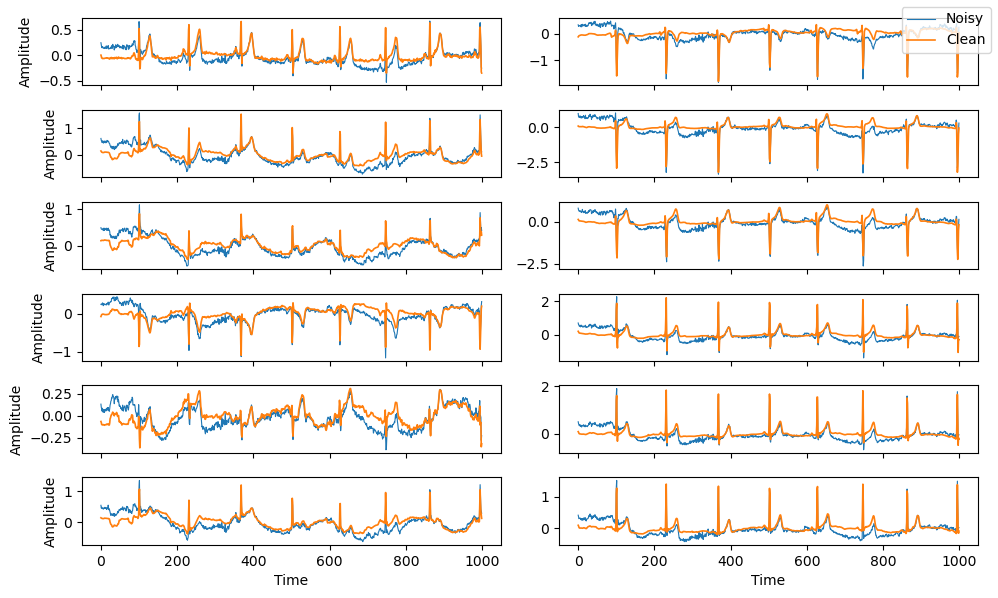

In [49]:
sample_idx = 1  # index of the sample to plot

import matplotlib.pyplot as plt

fig, axs = plt.subplots(6, 2, figsize=(10, 6), sharex=True)

for i in range(6):
    for j in range(2):
        channel = i if j == 0 else i + 6
        # Plot noisy first, clean second (so clean is on top)
        axs[i, j].plot(noisy_ecg[sample_idx, :, channel], lw=0.8, label="Noisy" if (i==0 and j==0) else "")
        axs[i, j].plot(clean_ecg[sample_idx, :, channel], lw=1.2, label="Clean" if (i==0 and j==0) else "")

for ax in axs[-1, :]:
    ax.set_xlabel("Time")

for i in range(6):
    axs[i, 0].set_ylabel("Amplitude")

fig.legend(["Noisy", "Clean"], loc="upper right")
plt.tight_layout()
plt.show()